In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
import torch.quantization
from sklearn.metrics import recall_score

plt.ion()  

## Transfer learning
Стандартный препроцессинг

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'MeGlass_120x120'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

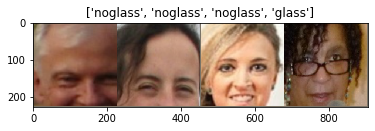

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Learning

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() 
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

В качестве легковесной модели возьмем squeezenet1_1, [сравнение моделей](https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/)


In [7]:
model_ft = torch.hub.load('pytorch/vision', 'squeezenet1_1', pretrained=True)
model_ft.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in /home/sultan/.cache/torch/hub/pytorch_vision_master


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6951 Acc: 0.5088
val Loss: 0.6931 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.6913 Acc: 0.5094
val Loss: 0.6932 Acc: 0.4994

Epoch 2/24
----------
train Loss: 0.6553 Acc: 0.5836
val Loss: 0.5081 Acc: 0.7833

Epoch 3/24
----------
train Loss: 0.5889 Acc: 0.6205
val Loss: 0.6931 Acc: 0.5000

Epoch 4/24
----------
train Loss: 0.6923 Acc: 0.5278
val Loss: 0.6931 Acc: 0.5000

Epoch 5/24
----------
train Loss: 0.6922 Acc: 0.5211
val Loss: 0.6931 Acc: 0.5000

Epoch 6/24
----------
train Loss: 0.6869 Acc: 0.5102
val Loss: 0.6931 Acc: 0.5000

Epoch 7/24
----------
train Loss: 0.6494 Acc: 0.6424
val Loss: 0.6931 Acc: 0.5000

Epoch 8/24
----------
train Loss: 0.5714 Acc: 0.7085
val Loss: 0.6931 Acc: 0.5000

Epoch 9/24
----------
train Loss: 0.4425 Acc: 0.8015
val Loss: 0.2208 Acc: 0.9570

Epoch 10/24
----------
train Loss: 0.2500 Acc: 0.8950
val Loss: 0.0756 Acc: 0.9860

Epoch 11/24
----------
train Loss: 0.1874 Acc: 0.9228
val Loss: 0.1161 Acc: 0.9635

Ep

KeyboardInterrupt: 

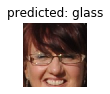

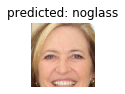

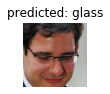

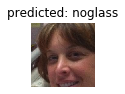

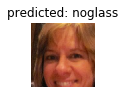

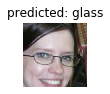

In [9]:
visualize_model(model_ft)

## Квантование

In [9]:
torch.save(model_ft, 'models/model_squeeze_1_1')
model_ft = torch.load('models/model_squeeze_1_1')

In [10]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [11]:
import torch.quantization

In [12]:
quantized_model = torch.quantization.quantize_dynamic(
    model_ft, {torch.squeeze, nn.Linear}, dtype=torch.qint8
)
print(quantized_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [13]:
print_size_of_model(model_ft)
print_size_of_model(quantized_model)

Size (MB): 2.904185
Size (MB): 2.904191


Особой разницы в весе нет, возможно проблема торча,  
так как возможность появилась только сейчас.  
Условие на **3 МБ** выполняется

## Test on example

Визуализация

In [15]:
data_transforms = {
    'example_data_glasses': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = ''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['example_data_glasses']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['example_data_glasses']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['example_data_glasses']}
class_names = image_datasets['example_data_glasses'].classes

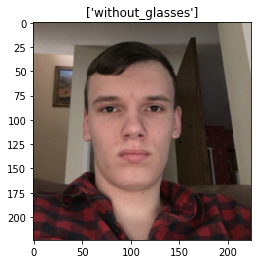

In [16]:
inputs, classes = next(iter(dataloaders['example_data_glasses']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Метрики и скорость

Условие на 100 мс выполняется, доля неверно классифицированных людей без очков 0.1,  
доля неверно классифицированных очкариков 0.

In [17]:
from PIL import Image
model_ft = torch.load('models/model_squeeze_1_1')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
model_ft.eval()


data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])



data_dir = 'result_test'
with torch.no_grad():
    for file in os.listdir(data_dir):
        test_image = Image.open(Path(data_dir) / file)    #Image.open(Path(data_dir) / file)
        test_image_tensor = data_transforms(test_image)

        inputs = test_image_tensor.to(device)
        outputs = model_ft(inputs.reshape((1,inputs.shape[0],inputs.shape[1],inputs.shape[2])))
        _, preds = torch.max(outputs, 1)


In [18]:
def evaluate(model, dltr):
    model.eval()
    
    with torch.no_grad():
        prds = []
        trs = []
        for i, (inputs, labels) in enumerate(dltr):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            prds.append(preds)
            trs.append(labels)
            
            # out = torchvision.utils.make_grid(inputs)
            # imshow(out)

        print(f'Recall for unglass (as 1) - {recall_score(trs, prds)}')      
        print(f'Recall for glass (as 1) - {recall_score(abs(np.array(trs) - 1), abs(np.array(prds) - 1))}')

In [19]:
evaluate(model_ft, dataloaders['example_data_glasses'])

Recall for unglass (as 1) - 1.0
Recall for glass (as 1) - 0.9
